In [2]:
import pandas as pd
import arviz as az
import pickle
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols


### Step 1: Read model objects and data
This uses already fitted model objects fit in Stan. Change extended to False to run analyses on models with fixed non-decision time

In [25]:
extended = True # switch to True if you wish to run analyses for models including non-decision time

az_dict = {} # create a dicitonary of all netcdf Stan model outputs
df_dict = {} # create a dictionary of all csvs containing d-scores and explicit preferences
n_dict = {} # create a dictionary of total sample sizes for each IAT (every subject that went into group-level parameters in model, not just those with subject-level estimates)
for x in ['possiblecertain', 'labormanagement', 'statechurch', 'socialismcapitalism', 'complexsimple', 'protestaccept',
          'fairbiased', 'democracyfascism', 'motherfather', 'hopeduty', 'selfother', 'regulationmarkets',
          'progressrestore', 'newold', 'non-profitscorporations', '20501950', 'ambiguousclear',
          'defendattack', 'changepreserve', 'collectiveindividual', 'communityindividual', 'individualgroup',
          'forwardbackward', 'equalunequal', 'anarchyhierarchy', 'justiceinjustice',
          'novelfamiliar', 'foreignlocal', 'nurturingstrict',
          'presentpast', 'blackwhite', 'gaystraight', 'riskycautious', 'futurepresent', '20501950_ds', 
          'dangersafety_tf', 'sciencereligion_tf', 'conspiracyaccident_tf', 'evolutioncreationism_tf']:
    try:
        if extended == False:
            az_dict[x] = az.from_netcdf('models/standard/raceddm_%s.nc' % x)
        elif extended == True:
            az_dict[x] = az.from_netcdf('models/extended/raceddm_%s.nc' % x)
        df_dict[x] = pd.read_csv('data/%s.csv' % x)
        with open('pickles/%s.pkl' % x, 'rb') as f:
            data = pickle.load(f)
        n_dict[x] = data['N']
    except:
        pass

### Step 2: Make dictionaries
This cell creates dictionaries that store each IAT's block numbers, upper and lower thresholds for the RDMs, and tick labels

In [26]:
# make a dictionary with keys for each IAT, and all RDM thresholds for "Action B". Four different thresholds for four different blocks.
accumulator_b_dict = {'20501950_ds': ['2050', 'Safety', '2050/Safety', '1950/Safety'],
                   '20501950': ['1950', 'Bad', '1950/Bad', '2050/Bad'],
                   'ambiguousclear': ['Ambiguous', 'Bad', 'Ambiguous/Bad', 'Clear/Bad'],
                   'anarchyhierarchy': ['Anarchy', 'Bad', 'Anarchy/Bad', 'Hierarchy/Bad'],
                   'changepreserve': ['Preserve', 'Bad', 'Preserve/Bad', 'Change/Bad'],
                   'communityindividual': ['Individual', 'Bad', 'Individual/Bad', 'Community/Bad'],
                  'collectiveindividual': ['Individual', 'Bad', 'Individual/Bad', 'Collective/Bad'],
                  'conspiracyaccident_tf': ['Conspiracy', 'False', 'Conspiracy/False', 'Accident/False'],
                  'defendattack': ['Attack', 'Bad', 'Attack/Bad', 'Defend/Bad'],
                  'equalunequal': ['Unequal', 'Bad', 'Unequal/Bad', 'Equal/Bad'],
                  'evolutioncreationism_tf': ['Creationism', 'False', 'Creationism/False', 'Evolution/False'],
                  'foreignlocal': ['Foreign', 'Bad', 'Foreign/Bad', 'Local/Bad'],
                  'forwardbackward': ['Backward', 'Bad', 'Backward/Bad', 'Forward/Bad'],
                  'futurepresent': ['Future', 'Bad', 'Future/Bad', 'Present/Bad'],
                  'hopeduty': ['Duty', 'Bad', 'Duty/Bad', 'Hope/Bad'],
                  'individualgroup': ['Group', 'Bad', 'Group/Bad', 'Individual/Bad'],
                  'justiceinjustice': ['Injustice', 'Bad', 'Injustice/Bad', 'Justice/Bad'],
                  'motherfather': ['Father', 'Bad', 'Father/Bad', 'Mother/Bad'],
                  'newold': ['Old', 'Bad', 'Old/Bad', 'New/Bad'],
                  'non-profitscorporations': ['Corporations', 'Bad', 'Corporations/Bad', 'Non-Profits/Bad'],
                  'novelfamiliar': ['Novel', 'Bad', 'Novel/Bad', 'Familiar/Bad'],
                  'nurturingstrict': ['Strict', 'Bad', 'Strict/Bad', 'Nurturing/Bad'],
                  'presentpast': ['Past', 'Bad', 'Past/Bad', 'Present/Bad'],
                  'progressrestore': ['Restore', 'Bad', 'Restore/Bad', 'Progress/Bad'],
                  'regulationmarkets': ['Regulation', 'Bad', 'Regulation/Bad', 'Markets/Bad'],
                  'sciencereligion_tf': ['Religion', 'False', 'Religion/False', 'Science/False'],
                  'blackwhite': ['Black People', 'Bad', 'Black People/Bad', 'White People/Bad'],
                  'gaystraight': ['Gay People', 'Bad', 'Gay People/Bad', 'Straight People/Bad'],
                  'riskycautious': ['Risky', 'Bad', 'Risky/Bad', 'Cautious/Bad'],
                  'possiblecertain': ['Possible', 'Bad', 'Possible/Bad', 'Certain/Bad'],
                  'labormanagement': ['Labor', 'Bad', 'Labor/Bad', 'Management/Bad'],
                  'statechurch': ['State', 'Bad', 'State/Bad', 'Church/Bad'],
                  'socialismcapitalism': ['Socialism', 'Bad', 'Socialism/Bad', 'Capitalism/Bad'],
                  'complexsimple': ['Complex', 'Bad', 'Complex/Bad', 'Simple/Bad'],
                  'protestaccept': ['Protest', 'Bad', 'Protest/Bad', 'Accept/Bad'],
                  'fairbiased': ['Biased', 'Bad', 'Biased/Bad', 'Fair/Bad'],
                  'democracyfascism': ['Fascism', 'Bad', 'Fascism/Bad', 'Democracy/Bad'],
                  'dangersafety_tf': ['Danger', 'False', 'Danger/False', 'Safety/False'],
                  'selfother': ['Other', 'Bad', 'Other/Bad', 'Self/Bad']}

# make a dictionary of blocks with keys for each IAT. Blocks are recorded as integers for Stan to use as indices. 
# concept-only block = 1, attribute-only block = 2, compatible block = 3, incompatible block = 4
# for single-target IATs, concept-only block = 2, compatible block = 3, incompatible block = 4
block_dict = {}
for y in list(df_dict.keys()):
    tempdict = {}
    x = accumulator_b_dict[y]
    tempdict['%s,%s' % (x[0],x[3].split('/')[0])] = 1
    tempdict['%s,%s' % (x[3].split('/')[0],x[0])] = 1
    if x[1] == 'Bad':
            tempdict['Good,Bad'] = 2
            tempdict['%s/Good,%s' % (x[3].split('/')[0], x[2])] = 3
            tempdict['%s/Good,%s' % (x[0], x[3])] = 4
    elif x[1] == 'False':
            tempdict['True,False'] = 2
            tempdict['%s/True,%s' % (x[3].split('/')[0], x[2])] = 3
            tempdict['%s/True,%s' % (x[0], x[3])] = 4
    elif x[1] == 'Safety':
            tempdict['Danger,Safety'] = 2
            tempdict['%s/Danger,%s' % (x[3].split('/')[0], x[2])] = 3
            tempdict['%s/Danger,%s' % (x[0], x[3])] = 4
    block_dict[y] = tempdict

# ticks for figures
xticks = {'blackwhite': 'Race (X=Black, Y=White)',
          'gaystraight': 'Sexuality (X=Gay, Y=Straight)',
          'statechurch': 'Secularity (X=State, Y=Church)',
          'labormanagement': 'Employment (X=Labor, Y=Management)',
          'protestaccept': 'Protest (X=Protest, Y=Accept)',
          'socialismcapitalism': 'Economic Systems (X=Socialism, Y=Capitalism)',
          'complexsimple': 'Complexity (X=Complex, Y=Simple)',
          'fairbiased': 'Fairness (X=Biased, Y=Fair)',
          'democracyfascism': 'Government Systems (X=Fascism, Y=Democracy)',
          'motherfather': 'Parents (X=Father, Y=Mother)',
          '20501950_ds': 'Centuries-Danger (X=2050, Y=1950)',
          '20501950': 'Centuries (X=1950, Y=2050)',
          'anarchyhierarchy': 'Order (X=Anarchy, Y=Hierarchy)',
          'ambiguousclear': 'Clarity (X=Ambiguous, Y=Clear)',
          'changepreserve': 'Preservation (X=Preserve, Y=Change)',
          'communityindividual': 'Cultural Ideology II (X=Individual, Y=Community)',
          'collectiveindividual': 'Cultural Ideology I (X=Individual, Y=Collective)',
          'conspiracyaccident_tf': 'Explanations-Truth (X=Conspiracy, Y=Accident)',
          'defendattack': 'Strategy (X=Attack, Y=Defend)',
          'equalunequal': 'Equality (X=Unequal, Y=Equal)',
          'evolutioncreationism_tf': 'Origins-Truth (X=Creationism, Y=Evolution)',
          'foreignlocal': 'Location (X=Foreign, Y=Local)',
          'forwardbackward': 'Direction (X=Backward, Y=Forward)',
          'futurepresent': 'Time I (X=Future, Y=Present)',
          'hopeduty': 'Goals (X=Duty, Y=Hope)',
          'individualgroup': 'Cultural Ideology III (X=Group, Y=Individual)',
          'justiceinjustice': 'Justice (X=Injustice, Y=Justice)',
          'newold': 'Age (X=Old, Y=New)',
          'non-profitscorporations': 'Businesses (X=Corporations, Y=Non-Profits)',
          'novelfamiliar': 'Novelty (X=Novel, Y=Familiar)',
          'nurturingstrict': 'Parenting (X=Strict, Y=Nurturing)',
          'presentpast': 'Time II (X=Past, Y=Present)',
          'progressrestore': 'Steps (X=Restore, Y=Progress)',
          'regulationmarkets': 'Economic Policy (X=Regulation, Y=Markets)',
          'sciencereligion_tf': 'Philosophies-Truth (X=Religion, Y=Science)',
          'riskycautious': 'Risk (X=Risky, Y=Cautious)',
          'possiblecertain': 'Likelihood (X=Possible, Y=Certain)',
          'dangersafety_tf': 'Threat-Truth (X=Danger, Y=Safety)',
          'selfother': 'Identity (X=Other, Y=Self)'}

C:\Users\kjl113\AppData\Local\Temp\ipykernel_10072\942815187.py:77: RuntimeWarning: divide by zero encountered in double_scalars
  if ph0/ph1 >= 10: # if odds for H0 being in ROPE are 10:1 over H1, we claim strong evidence for H1 at that ROPEs effect size


evidence for 0.2 effect: 4446.628192323998
evidence for 0.5 effect: 4088.2395545027457
evidence for 0.8 effect: 3525.6529065323302
    index        value                                                IAT  \
10    0.0   972.230339                 Identity (X=Other, Y=Self) (N=820)   
15    0.0   977.317433                 Centuries (X=1950, Y=2050) (N=810)   
30    0.0   977.840908                    Race (X=Black, Y=White) (N=901)   
8     0.0   983.302885               Parents (X=Father, Y=Mother) (N=838)   
14    0.0   984.179587  Businesses (X=Corporations, Y=Non-Profits) (N=...   
7     0.0   985.012227  Government Systems (X=Fascism, Y=Democracy) (N...   
31    0.0   985.310229              Sexuality (X=Gay, Y=Straight) (N=837)   
11    0.0   985.491329  Economic Policy (X=Regulation, Y=Markets) (N=746)   
4     0.0   986.030307           Complexity (X=Complex, Y=Simple) (N=816)   
38    0.0   988.502985  Origins-Truth (X=Creationism, Y=Evolution) (N=...   
37    0.0   989.918131

C:\Users\kjl113\AppData\Local\Temp\ipykernel_10072\942815187.py:77: RuntimeWarning: divide by zero encountered in double_scalars
  if ph0/ph1 >= 10: # if odds for H0 being in ROPE are 10:1 over H1, we claim strong evidence for H1 at that ROPEs effect size


evidence for 0.2 effect: 2.1433341142145125e+171
evidence for 0.5 effect: 2.595871952908904e+170
evidence for 0.8 effect: 2.0465357885128803e+169
    index        value                                                IAT  \
10    0.0  1023.874709                 Identity (X=Other, Y=Self) (N=820)   
15    0.0  1023.028734                 Centuries (X=1950, Y=2050) (N=810)   
30    0.0  1004.231639                    Race (X=Black, Y=White) (N=901)   
8     0.0  1015.648080               Parents (X=Father, Y=Mother) (N=838)   
14    0.0  1017.537255  Businesses (X=Corporations, Y=Non-Profits) (N=...   
7     0.0  1081.373077  Government Systems (X=Fascism, Y=Democracy) (N...   
31    0.0  1034.731066              Sexuality (X=Gay, Y=Straight) (N=837)   
11    0.0   981.177375  Economic Policy (X=Regulation, Y=Markets) (N=746)   
4     0.0  1031.752724           Complexity (X=Complex, Y=Simple) (N=816)   
38    0.0   996.853424  Origins-Truth (X=Creationism, Y=Evolution) (N=...   
37    0

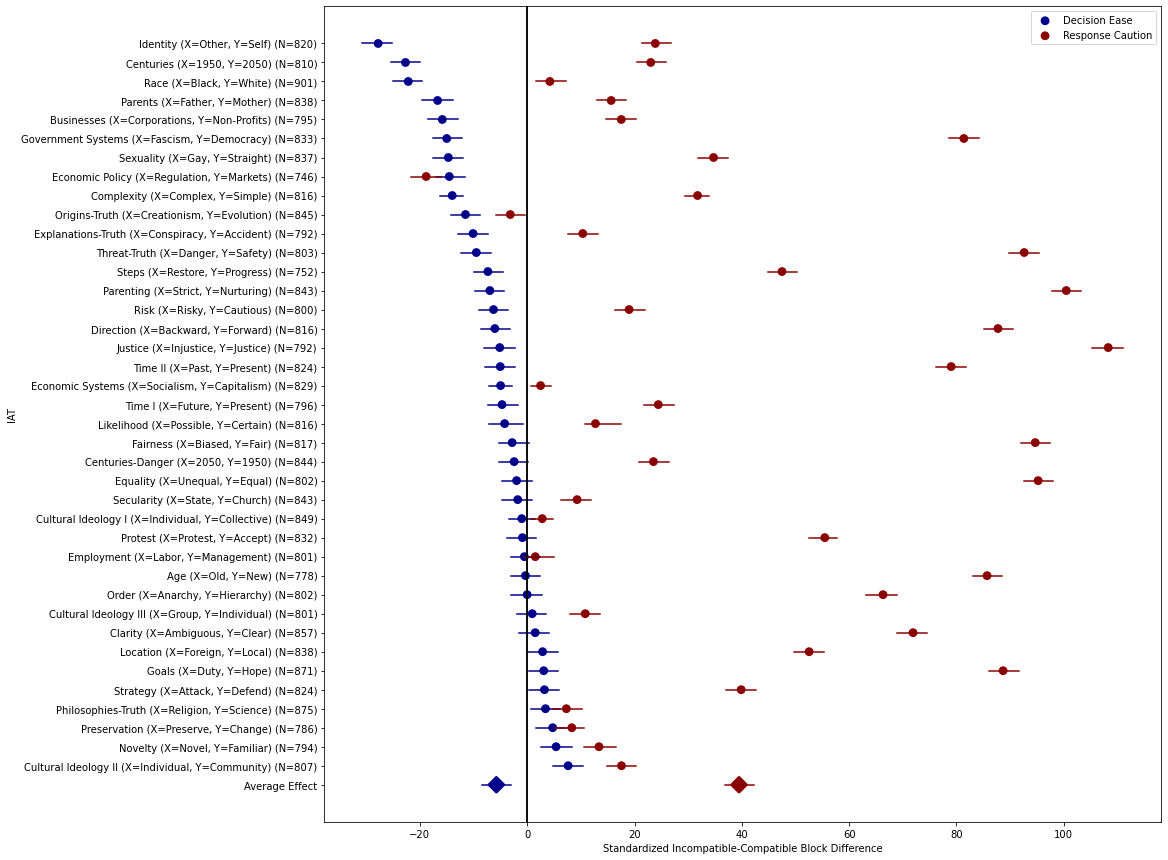

In [47]:
showndt = False # if extended=True and you'd like to view ndt estimates, change to True

forestdf_list = [] # make a list of forest plots

parlist = ['delta', 'alpha']
if (extended == True) and (showndt == True):
    parlist.append('tau')

for x in parlist: # first we'll go through the drift rates, then we'll go through the evidence thresholds
    nlist = [] # make a list of number of subjects included in the Stan model
    for i, iat in enumerate(list(block_dict.keys())): # loop through each IAT
        azdf = az_dict[iat] # get the Stan model result for an IAT
        cb=2; ib=3 # compatible and incompatible block indices
        if x == 'delta': # extract drift rates from the Stan model result
            compatible_accumulator_a = azdf.posterior['mu_v_upper'].stack(sample=('chain', 'draw')).sel({'mu_v_upper_dim_0': cb}).values
            compatible_accumulator_b = azdf.posterior['mu_v_lower'].stack(sample=('chain', 'draw')).sel({'mu_v_lower_dim_0': cb}).values
            incompatible_accumulator_a = azdf.posterior['mu_v_upper'].stack(sample=('chain', 'draw')).sel({'mu_v_upper_dim_0': ib}).values
            incompatible_accumulator_b = azdf.posterior['mu_v_lower'].stack(sample=('chain', 'draw')).sel({'mu_v_lower_dim_0': ib}).values
            compatible_accumulator_a_sd = azdf.posterior['sigma_v_upper'].stack(sample=('chain', 'draw')).sel({'sigma_v_upper_dim_0': cb}).values
            compatible_accumulator_b_sd = azdf.posterior['sigma_v_lower'].stack(sample=('chain', 'draw')).sel({'sigma_v_lower_dim_0': cb}).values
            incompatible_accumulator_a_sd = azdf.posterior['sigma_v_upper'].stack(sample=('chain', 'draw')).sel({'sigma_v_upper_dim_0': ib}).values
            incompatible_accumulator_b_sd = azdf.posterior['sigma_v_lower'].stack(sample=('chain', 'draw')).sel({'sigma_v_lower_dim_0': ib}).values
            compatible = (compatible_accumulator_a + compatible_accumulator_b) / 2 # get the average of the two drift rates for compatible
            incompatible = (incompatible_accumulator_a + incompatible_accumulator_b) / 2 # get the average of the two drift rates for incompatible
            compatible_sd = (compatible_accumulator_a_sd + compatible_accumulator_b_sd) / 2 # get the average of the two drift rates for compatible
            incompatible_sd = (incompatible_accumulator_a_sd + incompatible_accumulator_b_sd) / 2
        else: # extract evidence thresholds (and ndt for extended models) from the Stan model result
            compatible = azdf.posterior['mu_%s' % x].stack(sample=('chain', 'draw')).sel({'mu_%s_dim_0' % x: cb}).values
            incompatible = azdf.posterior['mu_%s' % x].stack(sample=('chain', 'draw')).sel({'mu_%s_dim_0' % x: ib}).values
            compatible_sd = azdf.posterior['sigma_%s' % x].stack(sample=('chain', 'draw')).sel({'sigma_%s_dim_0' % x: cb}).values
            incompatible_sd = azdf.posterior['sigma_%s' % x].stack(sample=('chain', 'draw')).sel({'sigma_%s_dim_0' % x: ib}).values
        difference = (incompatible - compatible) / np.sqrt((np.var(incompatible) + np.var(compatible))/2)# get the standardized difference of the incompatible and compatible distributions
   
        # create a temporary dataframe with the mean of the standardized difference, IAT name, and 95% HDI
        tempdf = pd.DataFrame({'value': [np.mean(difference)],
                                'IAT': [xticks[iat]+" (N="+str(n_dict[iat])+")"],
                                'Upper': [az.hdi(difference, hdi_prob=0.95)[1]],
                                'Lower': [az.hdi(difference, hdi_prob=0.95)[0]],
                                'SD': [np.std(difference)]})
        nlist.append(n_dict[iat]) # append to nlist the total number of subjects for this IAT

        # create a larger dataframe concatenating together the temporary dataframes for each IAT
        # resulting in one dataframe with all mean standardized differences, IAT names, and 95% HDIs
        if i == 0:
            forestdf = tempdf.copy()
        else:
            forestdf = pd.concat([forestdf, tempdf])

    forestdf_list.append(forestdf.reset_index()) # append the final dataframe to a list that will have two total frames, one for average drift rate and another for evidence threshold

for j, fdf in enumerate(forestdf_list): # loop through the dataframes containing summarized drift rates and evidence thresholds
    if j ==0: # if the first parameter, we need to sort ascending for graph, and save the index order for subsequent graphs
        graph_min = min(fdf['Lower']); graph_max = max(fdf['Upper']) # get the smallest and largest CIs for graphing purposes
        fig, ax = plt.subplots(figsize=(15, 15))
        ylist = []
        for i, mymodel in enumerate(list(block_dict.keys())):
            ylist.append([i, i]) # list of y values for plotting the HDIs
        ylist.append([i+1, i+1]) # add an extra y value for plotting the mean effect HDIs
        thisfdf = fdf.sort_values('value', ascending=True) # sort the summary stats for the IATs in ascending order
        oldindex = thisfdf.index # copy the index list of the ascending IATs
    else:
        # update the smallest and largest CIs for graphing purposes
        if min(fdf['Lower']) < graph_min:
            graph_min = min(fdf['Lower'])
        if max(fdf['Upper']) > graph_max:
            graph_max = max(fdf['Upper'])
        thisfdf = fdf.copy().reindex(oldindex) # if not the first parameter, reindex the dataframe to match that of the first parameter

    tocsvdf = thisfdf.copy().reset_index()
    tocsvdf['save'] = ['%.3f (%.3f, %.3f)' % (v, tocsvdf['Lower'][k], tocsvdf['Upper'][k]) for k, v in enumerate(tocsvdf['value'])]
    bflist = []; asterisks = ['*', '**', '***']
    for k, v in enumerate(tocsvdf['value']):
        bfval = ''
        for r, rope in enumerate([.1, .25, .4]): # check all ROPEs for small, moderate, and large effect sizes
            ph1 = st.norm.cdf(rope, v, tocsvdf['SD'][k]) - st.norm.cdf(-rope, v, tocsvdf['SD'][k]) # probability of posterior H1 estimate being in ROPE
            ph0 = st.cauchy.cdf(rope, 0, 1) - st.cauchy.cdf(-rope, 0, 1) # probability of H0 being in ROPE (H0 is Cauchy with scale=1)
            if ph0/ph1 >= 10: # if odds for H0 being in ROPE are 10:1 over H1, we claim strong evidence for H1 at that ROPEs effect size
                bfval = asterisks[r]
        bflist.append(bfval)
    tocsvdf['save'] = ["%s%s" % (cval, bflist[c]) for c, cval in enumerate(tocsvdf['save'])]
    tocsvdf.to_csv('tempsave_%s.csv' % parlist[j])


    # first we're only plotting the mean standardized differences for each IAT, but since we'll separately plot the average effect, we need to have an extra
    # y tick. So we'll add a final set of values to the dataframe that goes off the axis limit (won't see it, but it will create the extra tick for later)
    thisfdf_last = pd.DataFrame({'IAT': ['Average Effect'], 'value': [1000],
                            'Lower': [999], 'Upper': [1001]})
    final = pd.concat([thisfdf, thisfdf_last]) # add the extra y-tick to the end of the summary dataframe
    if j == 0:
        pointcolor = 'darkblue'
        label = 'Decision Ease'
    elif j ==1:
        pointcolor = 'darkred'
        label = 'Response Caution'
    else:
        pointcolor = 'red'
        label = 'Non-Decision Time'
    sns.pointplot(data=final, x='value', y='IAT', join=False, color=pointcolor, label=label, markers="o", scale=1) # plot the mean effect for each IAT
    plt.plot(np.asarray(final[['Lower', 'Upper']]).T, np.asarray(ylist).T, color=pointcolor) # plot the HDIs around each mean effect

    # now we can separately plot and overlay the average effect across IATs. Similar to before, we'll shift all the values we don't need off the axis limit.
    thisfdf2 = thisfdf.copy()
    thisfdf2['value']=thisfdf2['value']+1000
    thisfdf2['Lower']=thisfdf2['Lower']+1000
    thisfdf2['Upper']=thisfdf2['Upper']+1000
    # all we need is the average effect. Take the mean of the means and HDI bounds.
    thisfdf2_last = pd.DataFrame({'IAT': ['Average Effect'], 'value': [np.mean(thisfdf['value'])],
                            'Lower': [np.mean(thisfdf['Lower'])], 'Upper': [np.mean(thisfdf['Upper'])]})
    final = pd.concat([thisfdf2, thisfdf2_last])
    
    for rope in [.1, .25, .4]:
        ph1 = st.norm.cdf(rope, np.mean(thisfdf['value']), np.mean(thisfdf['SD'])) - st.norm.cdf(-rope, np.mean(thisfdf['value']), np.mean(thisfdf['SD']))
        ph0 = st.cauchy.cdf(rope, 0, 1) - st.cauchy.cdf(-rope, 0, 1)
        print('evidence for %s effect: %s' % (rope*2, ph0/ph1))

    sns.pointplot(data=final, x='value', y='IAT', join=False, color=pointcolor, markers="D", scale=1.5) # plot the average effect across IATs
    plt.plot(np.asarray(final[['Lower', 'Upper']]).T, np.asarray(ylist).T, color=pointcolor) # plot the average HDI bounds across IATs
    print(final)

    if j==0:
        plt.xlabel("Standardized Incompatible-Compatible Block Difference")
        plt.title('Drift Rate / Ease of Decision-Making')
    elif j ==1:
        plt.xlabel("Standardized Incompatible-Compatible Block Difference")
        plt.title('Evidence Threshold / Response Caution')
        plt.title('')
        plt.legend(loc='upper right')
    else:
        plt.xlabel("Standardized Incompatible-Compatible Block Difference")
        plt.title('Non-Decision Time')
        plt.title('')
        plt.legend(loc='upper right')
    plt.axvline(0, color='black')
    buffer = (graph_max - graph_min) / 20
    plt.xlim(graph_min - buffer, graph_max + buffer)

In [28]:
model_dict = {}
# create dictionaries to store OLS results
dexp_dict = {}; fchange2_dict = {}; fchange1_dict = {}; eased_dict = {}; rcd_dict = {}; easeexp_dict = {}; rcexp_dict = {}
test_dict = {}; ndtd_dict = {}; ndtexp_dict = {};

# create keys in each dictionary for different OLS regressions predicting different D-scores
for x in [fchange2_dict, fchange1_dict, eased_dict, rcd_dict, ndtd_dict, test_dict]:
    for y in ['d', 'd2', 'd3', 'd4', 'd5', 'd6']:
        x.update({y: {}})

for inum, iat in enumerate(list(block_dict.keys())):
    azdf = az_dict[iat] # get the Stan model result for an IAT
    modeldf = df_dict[iat].copy() # get the d-scores and explicit preferences. We'll add to this dictionary summary stats from the model for LMEs
    xlist = ['alpha', 'v_upper', 'v_lower']
    if extended == True:
        xlist.append('tau')
    for x in xlist:
        if (extended == True) or (x != 'tau' and extended == False):
            for y in range(4): # loop through each block
                nsubs = len(azdf.posterior[x]['%s_dim_0' % x])/4
                modeldf[x+str(y)] = azdf.posterior[x].mean(dim=['chain', 'draw']).sel({'%s_dim_0' % x: range(int(nsubs*y), int((nsubs*y)+nsubs))}).values
        else:
            modeldf[x] = azdf.posterior[x].mean(dim=['chain', 'draw']).values
    model_dict[iat] = modeldf
    newdf = pd.DataFrame({'d': modeldf['d'], 'd2': modeldf['d2'], 'd3': modeldf['d3'], 'd4': modeldf['d4'], 
                          'd5': modeldf['d5'], 'd6': modeldf['d6'], 'exp': modeldf['exp']}) # make a new dataframe with just the d-scores and explicit preference scores
    cb=2; ib=3 # indices for compatible and incompatible blocks

    for x in ['alpha', 'mean_v', 'tau']:
        if (x == 'alpha') or (x == 'tau' and extended == True):
            dif = modeldf['%s%s' % (x,ib)]-modeldf['%s%s' % (x,cb)] # get the difference in means between incompatible and compatible blocks for evidence threshold
            newdf[x] = dif
        elif x == 'mean_v':
            dif = ((modeldf['v_lower%s' % ib]+modeldf['v_upper%s' % ib])/2)-((modeldf['v_lower%s' % cb]+modeldf['v_upper%s' % cb])/2) # same as above, but for drift rate, and we're taking the average of the two.
            newdf[x] = dif

    # Supplemental Aim: Predict explicit preference with D-scores
    model = ols("exp ~ d", st.mstats.zscore(newdf)).fit()
    # add standardedized beta, 95% CIs, and number of observations to dictionary
    dexp_dict[iat] = [model.params[1], [model.conf_int()[0][1], model.conf_int()[1][1]], model.nobs, model.pvalues[1]]

    # Aim 2: Hierarchical regression
    for i, x in enumerate(['', '2', '3', '4', '5', '6']):
        if extended == True:
            newdf_d = newdf[['d'+x, 'mean_v', 'alpha', 'tau']].dropna()
        else:
            newdf_d = newdf[['d'+x, 'mean_v', 'alpha']].dropna()
        biasmodel = ols("%s ~ mean_v" % ("d" + x), st.mstats.zscore(newdf_d)).fit()
        biascautionmodel = ols("%s ~ mean_v + alpha" % ("d" + x), st.mstats.zscore(newdf_d)).fit()
        if extended == True:
            biasndtmodel = ols("%s ~ mean_v + tau" % ("d" + x), st.mstats.zscore(newdf_d)).fit()
            biascautionndtmodel = ols("%s ~ mean_v + alpha + tau" % ("d" + x), st.mstats.zscore(newdf_d)).fit()

        if extended == False:
        # from the second model block, add the standardized betas, 95% CIs, and number of observations to dictionaries
            eased_dict["d"+x][iat] = [biascautionmodel.params[1], [biascautionmodel.conf_int()[0][1], biascautionmodel.conf_int()[1][1]], biascautionmodel.nobs, biascautionmodel.pvalues[1]]
            rcd_dict["d"+x][iat] = [biascautionmodel.params[2], [biascautionmodel.conf_int()[0][2], biascautionmodel.conf_int()[1][2]], biascautionmodel.nobs, biascautionmodel.pvalues[2]]
            test_dict["d"+x].update({iat:i})

        else:
        # from the third model block
            eased_dict["d"+x][iat] = [biascautionndtmodel.params[1], [biascautionndtmodel.conf_int()[0][1], biascautionndtmodel.conf_int()[1][1]], biascautionndtmodel.nobs, biascautionndtmodel.pvalues[1]]
            rcd_dict["d"+x][iat] = [biascautionndtmodel.params[2], [biascautionndtmodel.conf_int()[0][2], biascautionndtmodel.conf_int()[1][2]], biascautionndtmodel.nobs, biascautionndtmodel.pvalues[2]]
            ndtd_dict["d"+x][iat] = [biascautionndtmodel.params[3], [biascautionndtmodel.conf_int()[0][3], biascautionndtmodel.conf_int()[1][3]], biascautionndtmodel.nobs, biascautionndtmodel.pvalues[3]]
            test_dict["d"+x].update({iat:i})

        # calculate the standard error in R2 for each model block, using number of observations, model degrees of freedom, and R2
        nobs = biasmodel.nobs
        if extended == False:
            k = 1
            r21 = biasmodel.rsquared
        else:
            k = 2
            r21 = biascautionmodel.rsquared
        ser21 = np.sqrt((4*r21*((1-r21)**2)*((nobs-k-1)**2))/((nobs**2-1)*(nobs + 3)))
        if extended == False:
            k = 2
            r22 = biascautionmodel.rsquared
        else:
            k = 3
            r22 = biascautionndtmodel.rsquared
        ser22 = np.sqrt((4*r22*((1-r22)**2)*((nobs-k-1)**2))/((nobs**2-1)*(nobs + 3)))
        
        if extended == False:
        # for each model block, add R2, SE bounds, number of observations, and F-change in comparison to first model block
            fchange2_dict["d"+x][iat] = [r22, [r22-ser22, r22+ser22], biascautionmodel.nobs, biascautionmodel.compare_f_test(biasmodel)[1]]
            fchange1_dict["d"+x][iat] = [r21, [r21-ser21, r21+ser21], biascautionmodel.nobs, biascautionmodel.compare_f_test(biasmodel)[1]]
    
        else:
        # NDT
            fchange2_dict["d"+x][iat] = [r22, [r22-ser22, r22+ser22], biascautionndtmodel.nobs, biascautionndtmodel.compare_f_test(biasndtmodel)[1]]
            fchange1_dict["d"+x][iat] = [r21, [r21-ser21, r21+ser21], biascautionndtmodel.nobs, biascautionndtmodel.compare_f_test(biasndtmodel)[1]]

    if extended == False:
    # Aim 3: Predict explicit preference with RDM params
        newdf_exp = newdf[['exp', 'mean_v', 'alpha']].dropna()
        model = ols("exp ~ mean_v + alpha", st.mstats.zscore(newdf_exp)).fit()
        easeexp_dict[iat] = [model.params[1], [model.conf_int()[0][1], model.conf_int()[1][1]], model.nobs, model.pvalues[1]]
        rcexp_dict[iat] = [model.params[2], [model.conf_int()[0][2], model.conf_int()[1][2]], model.nobs, model.pvalues[2]]

    else:
    # Aim 3.s1: Predict explicit preference with RDM params
        model = ols("exp ~ mean_v + alpha + tau", st.mstats.zscore(newdf)).fit()
        easeexp_dict[iat] = [model.params[1], [model.conf_int()[0][1], model.conf_int()[1][1]], model.nobs, model.pvalues[1]]
        rcexp_dict[iat] = [model.params[2], [model.conf_int()[0][2], model.conf_int()[1][2]], model.nobs, model.pvalues[1]]
        ndtexp_dict[iat] = [model.params[3], [model.conf_int()[0][3], model.conf_int()[1][3]], model.nobs, model.pvalues[1]]
    print("OLS ran for %s IAT datasets" % (inum+1))
    

OLS ran for 1 IAT datasets
OLS ran for 2 IAT datasets
OLS ran for 3 IAT datasets
OLS ran for 4 IAT datasets
OLS ran for 5 IAT datasets
OLS ran for 6 IAT datasets
OLS ran for 7 IAT datasets
OLS ran for 8 IAT datasets
OLS ran for 9 IAT datasets
OLS ran for 10 IAT datasets
OLS ran for 11 IAT datasets
OLS ran for 12 IAT datasets
OLS ran for 13 IAT datasets
OLS ran for 14 IAT datasets
OLS ran for 15 IAT datasets
OLS ran for 16 IAT datasets
OLS ran for 17 IAT datasets
OLS ran for 18 IAT datasets
OLS ran for 19 IAT datasets
OLS ran for 20 IAT datasets
OLS ran for 21 IAT datasets
OLS ran for 22 IAT datasets
OLS ran for 23 IAT datasets
OLS ran for 24 IAT datasets
OLS ran for 25 IAT datasets
OLS ran for 26 IAT datasets
OLS ran for 27 IAT datasets
OLS ran for 28 IAT datasets
OLS ran for 29 IAT datasets
OLS ran for 30 IAT datasets
OLS ran for 31 IAT datasets
OLS ran for 32 IAT datasets
OLS ran for 33 IAT datasets
OLS ran for 34 IAT datasets
OLS ran for 35 IAT datasets
OLS ran for 36 IAT datasets
O

In [29]:
# this function converts one of the dictionaries created from the previous OLS block into a dataframe. 
# each row of the dataframe is an IAT, including that IATs standardized beta, 95% confidence interval, and p-value
def createtable(dict):
    pdiats = []; pdeffects = []; pdlower = []; pdupper = []; pdpval = []; nlist = []
    for i in dict.keys():
        pdiats.append(xticks[i]+" (N="+str(int(dict[i][2]))+")")
        pdeffects.append(dict[i][0])
        pdlower.append(dict[i][1][0])
        pdupper.append(dict[i][1][1])
        pdpval.append(dict[i][3])
        nlist.append(int(dict[i][2]))
    table = pd.DataFrame({'IAT': pdiats, 'Effect': pdeffects,
                'Lower': pdlower, 'Upper': pdupper, 'Pval': pdpval})
    return table, nlist

# this function plots the standardized betas and 95% CIs for each IAT. It also adds an additional row that contains the average effect of all IATs
def plottable(table, color, label, xlist, single=True):
    table2 = pd.DataFrame({'IAT': ['Average Effect'], 'Effect': [1000],
                        'Lower': [999], 'Upper': [1001]})
    table3 = pd.concat([table, table2])
    sns.pointplot(data=table3, x='Effect', y='IAT', join=False, color=color, label=label)
    plt.plot(np.asarray(table3[['Lower', 'Upper']]).T, np.asarray(xlist).T, color=color)
    table4 = table.copy()
    table4['Effect']=table4['Effect']+1000
    table4['Lower']=table4['Lower']+1000
    table4['Upper']=table4['Upper']+1000
    table2 = pd.DataFrame({'IAT': ['Average Effect'], 'Effect': [np.mean(table['Effect'])],
                        'Lower': [np.mean(table['Lower'])], 'Upper': [np.mean(table['Upper'])]})
    table5 = pd.concat([table4, table2])
    print(np.mean(table['Effect']))
    print(np.mean(table['Lower']))
    print(np.mean(table['Upper']))
    if single == True:
        color = 'crimson'
    sns.pointplot(data=table5, x='Effect', y='IAT', join=False, color=color, markers="D", scale=1.5)
    plt.plot(np.asarray(table5[['Lower', 'Upper']]).T, np.asarray(xlist).T, color=color)
    plt.axvline(0, )

# list of spacings for graphing the different IATs
xlist = []
for i, mymodel in enumerate(list(block_dict.keys())):
    xlist.append([i, i])
xlist.append([i+1, i+1])

2787
0.26049656795386966
0.032680225065649805
0.4883129108420897


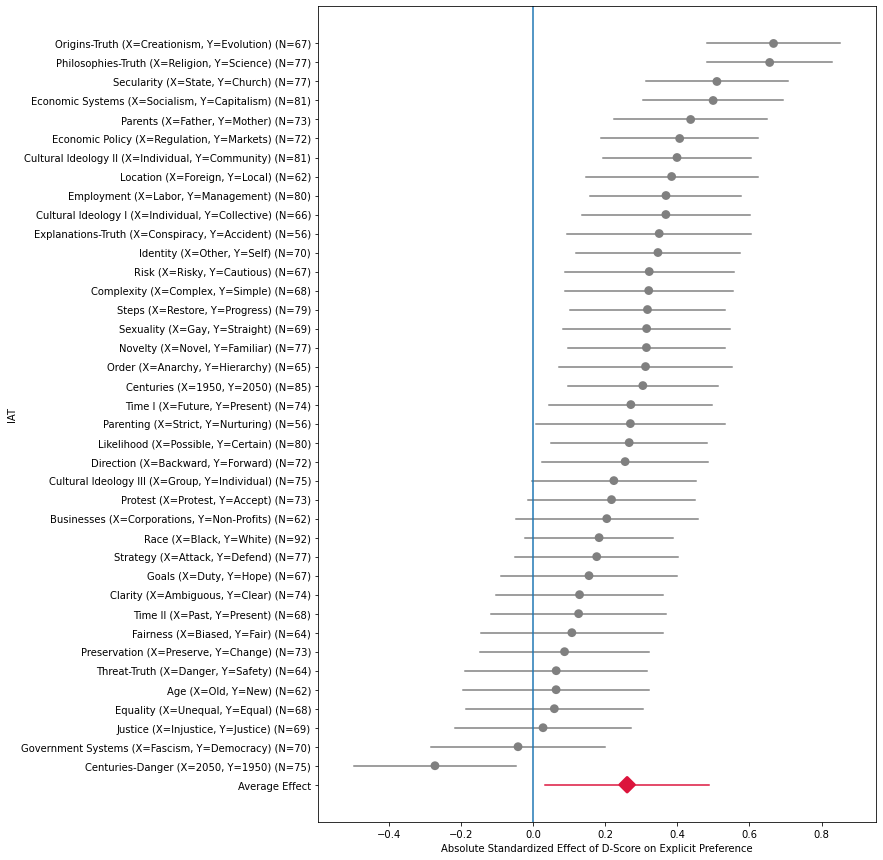

In [30]:
fig, ax = plt.subplots(figsize=(10, 15))
temp, nlist = createtable(dexp_dict)
print(np.sum(nlist))
temp = temp.sort_values('Effect', ascending=False)
plottable(temp, ".5", "", xlist)
plt.xlabel("Absolute Standardized Effect of D-Score on Explicit Preference")
plt.xlim(np.min(temp['Lower'])-0.1, np.max(temp['Upper'])+0.1)
plt.show()

2787
0.7835744326067233
0.7424238913290356
0.8247249738844109
0.6326235104008915
0.5690453140787773
0.6962017067230055


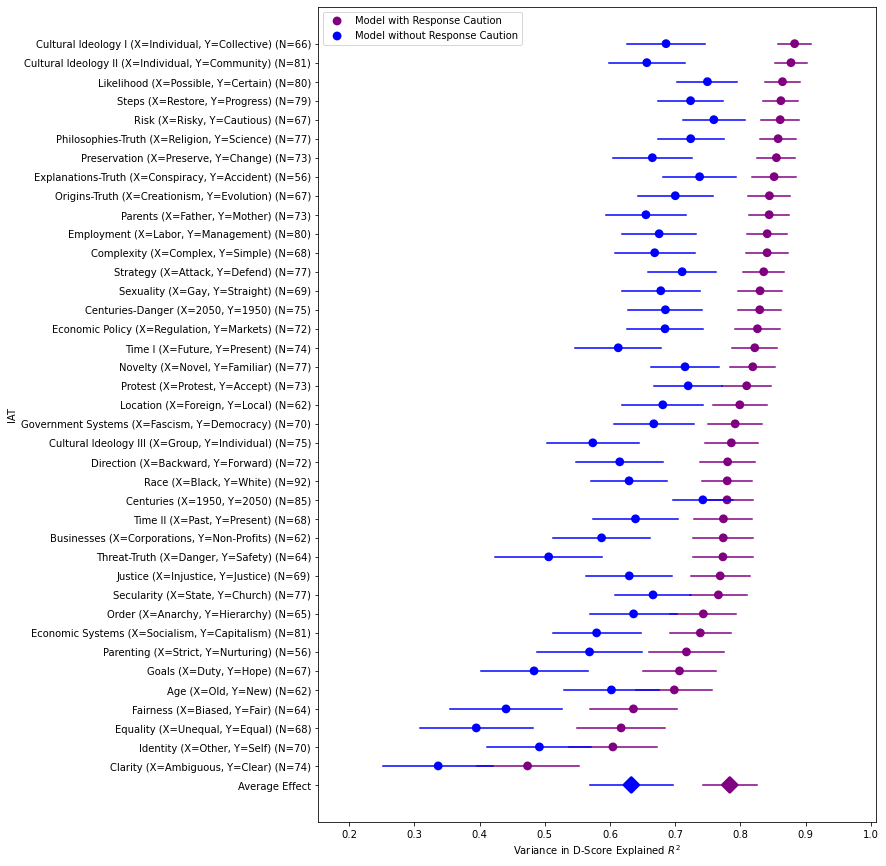

In [32]:
fig, ax = plt.subplots(figsize=(10, 15))
temp, nlist = createtable(fchange2_dict['d'])
print(np.sum(nlist))
temp = temp.sort_values('Effect', ascending=False)
oldindex = temp.index
plottable(temp, "purple", "Model with Response Caution", xlist, single=False)
graph_min = np.min(temp['Lower']); graph_max = np.max(temp['Upper'])
temp, nlist = createtable(fchange1_dict['d'])
temp = temp.reindex(oldindex)
plottable(temp, "blue", "Model without Response Caution", xlist, single=False)
if np.min(temp['Lower']) < graph_min:
    graph_min = np.min(temp['Lower'])
if np.max(temp['Upper']) > graph_max:
    graph_max = np.max(temp['Upper'])
plt.xlabel(r"Variance in D-Score Explained $R^{2}$")
plt.xlim(graph_min-0.1, graph_max+0.1)
plt.legend()
plt.show()

2787
0.35303900322814374
0.23558784151018863
0.4704901649460992
0.9654864384192734
0.8266532782740523
1.1043195985644947


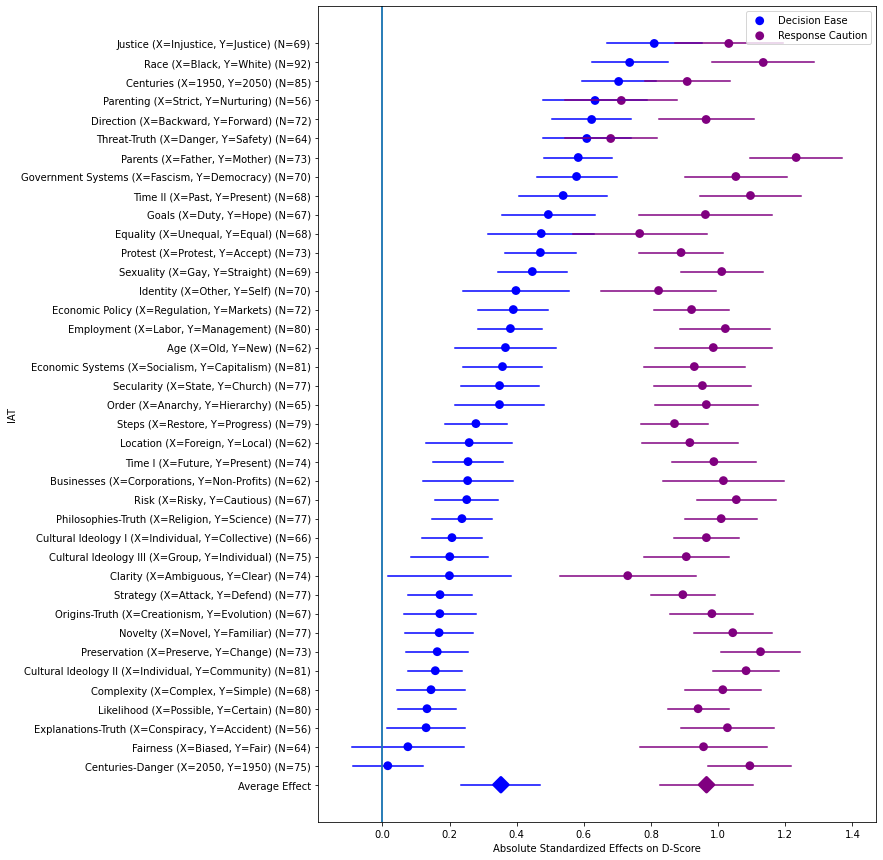

In [41]:
showndt = False

fig, ax = plt.subplots(figsize=(10, 15))
temp, nlist = createtable(eased_dict['d'])
print(np.sum(nlist))
temp['Effect'] = temp['Effect']*(-1)
flip_high = temp['Lower']*(-1)
flip_low = temp['Upper']*(-1)
temp['Lower'] = flip_low
temp['Upper'] = flip_high
temp = temp.sort_values('Effect', ascending=False)
oldindex = temp.index
plottable(temp, "blue", "Decision Ease", xlist, single=False)
graph_min = np.min(temp['Lower']); graph_max = np.max(temp['Upper'])

temp, nlist = createtable(rcd_dict['d'])
temp = temp.reindex(oldindex)
plottable(temp, "purple", "Response Caution", xlist, single=False)
if np.min(temp['Lower']) < graph_min:
    graph_min = np.min(temp['Lower'])
if np.max(temp['Upper']) > graph_max:
    graph_max = np.max(temp['Upper'])
if showndt == True:
    temp, nlist = createtable(ndtd_dict['d'])
    temp = temp.reindex(oldindex)
    plottable(temp, "red", "Non-Decision Time", xlist, single=False)
    if np.min(temp['Lower']) < graph_min:
        graph_min = np.min(temp['Lower'])
    if np.max(temp['Upper']) > graph_max:
        graph_max = np.max(temp['Upper'])
plt.xlabel("Absolute Standardized Effects on D-Score")
plt.xlim(graph_min-0.1, graph_max+0.1)
plt.legend()
plt.show()

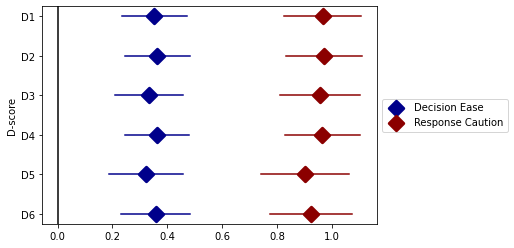

In [45]:
newxlist = []
for i in range(6):
    newxlist.append([i, i])

dlabels = {'d': 'D1', 'd2': 'D2', 'd3': 'D3', 'd4': 'D4', 'd5': 'D5', 'd6': 'D6'}

for dprint in ['d', 'd2', 'd3', 'd4', 'd5', 'd6']:
    dictlist = [eased_dict[dprint], rcd_dict[dprint]]
    for l, x in enumerate(dictlist):
        param = "Decision Ease"
        if l==1:
            param = "Response Caution"
        elif l==2:
            param = "Non-Decision Time"
        pdeffects = []; pdlower = []; pdupper = []
        if l==1 or l==2:
            for i in x.keys():
                pdeffects.append(x[i][0])
                pdlower.append(x[i][1][0])
                pdupper.append(x[i][1][1])
        else:
            for i in x.keys():
                pdeffects.append(x[i][0]*-1)
                pdlower.append(x[i][1][0]*-1)
                pdupper.append(x[i][1][1]*-1)
        temp = pd.DataFrame({'D-score': [dlabels[dprint]], 'Effect': [np.mean(pdeffects)],
                        'Lower': [np.mean(pdlower)], 'Upper': [np.mean(pdupper)], 'Parameter': [param]})
        if dprint == 'd' and l == 0:
            final = temp.copy()
        else:
            final = pd.concat([final, temp])
sns.pointplot(data=final, x='Effect', y='D-score', join=False, hue='Parameter', markers="D", scale=1.5, palette=['darkblue', 'darkred', 'red'])
plt.plot(np.asarray(final[final['Parameter']=="Response Caution"][['Lower', 'Upper']]).T, np.asarray(newxlist).T, color='darkred')
plt.plot(np.asarray(final[final['Parameter']=="Decision Ease"][['Lower', 'Upper']]).T, np.asarray(newxlist).T, color='darkblue')
# plt.plot(np.asarray(final[final['Parameter']=="Non-Decision Time"][['Lower', 'Upper']]).T, np.asarray(xlist).T, color='red')
plt.axvline(0, color='black')
plt.xlabel("")
plt.title("")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

2787
-0.04455074031220018
-0.2864935241870077
0.19739204356260734


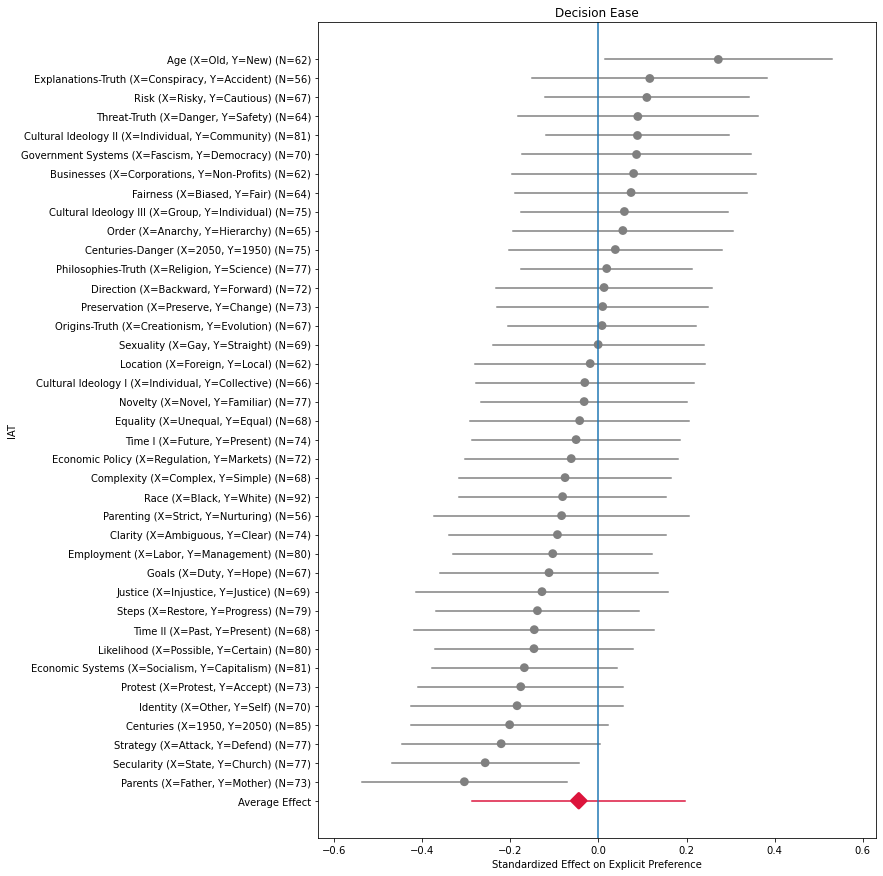

2787
0.26537311514571055
-0.020706760111658954
0.55145299040308


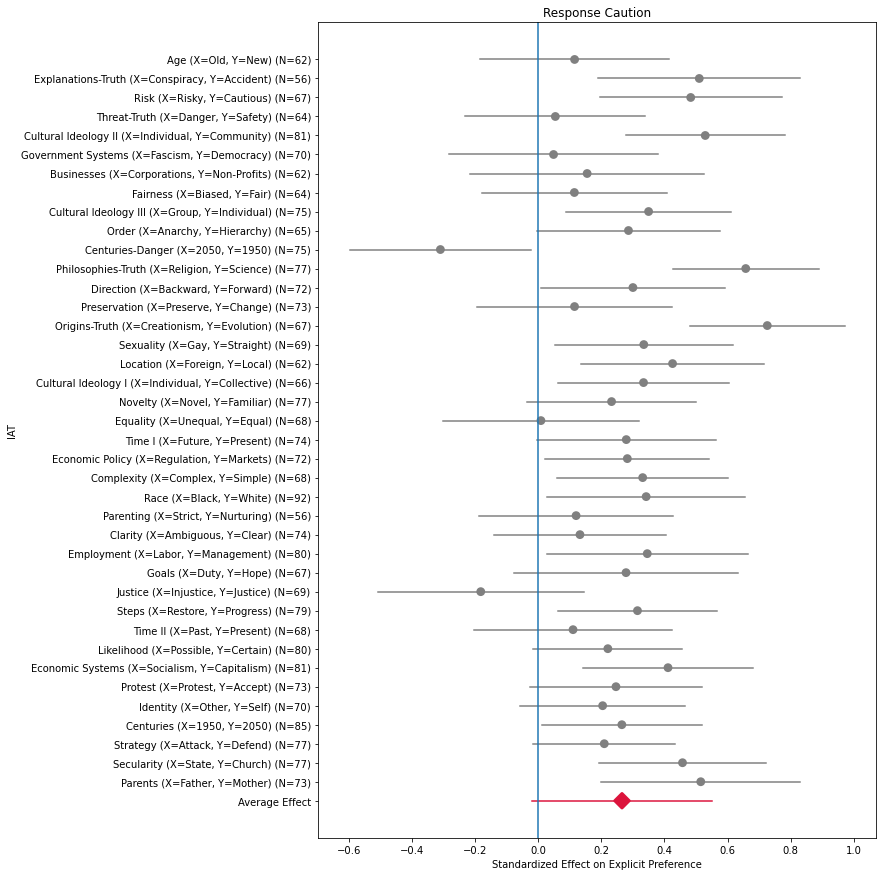

In [43]:
showndt = False

fig, ax = plt.subplots(figsize=(10, 15))
temp, nlist = createtable(easeexp_dict)
print(np.sum(nlist))
temp = temp.sort_values('Effect', ascending=False)
oldindex = temp.index
plottable(temp, ".5", "", xlist)
plt.xlabel("Standardized Effect on Explicit Preference")
plt.xlim(np.min(temp['Lower'])-0.1, np.max(temp['Upper'])+0.1)
plt.title("Decision Ease")
plt.show()

fig, ax = plt.subplots(figsize=(10, 15))
temp, nlist = createtable(rcexp_dict)
print(np.sum(nlist))
temp = temp.reindex(oldindex)
plottable(temp, ".5", "", xlist)
plt.xlabel("Standardized Effect on Explicit Preference")
plt.xlim(np.min(temp['Lower'])-0.1, np.max(temp['Upper'])+0.1)
plt.title("Response Caution")
plt.show()

if extended == True and showndt == True:
    fig, ax = plt.subplots(figsize=(10, 15))
    temp, nlist = createtable(ndtexp_dict)
    print(np.sum(nlist))
    temp = temp.reindex(oldindex)
    plottable(temp, ".5", "", xlist)
    plt.xlabel("Standardized Effect on Explicit Preference")
    plt.xlim(np.min(temp['Lower'])-0.1, np.max(temp['Upper'])+0.1)
    plt.title("Non-Decision Time")
    plt.show()